---
toc: false
page-layout: full
execute: 
  enabled: false
---

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas

np.random.seed(42)

In [2]:
pd.options.display.max_columns = 999

In [3]:
%matplotlib inline

# Week 12B: Predictive modeling with scikit-learn

- Nov 27, 2023
- Section 401


## The plan for today

- Wrap up our money vs. happiness example
- Introduce decision trees and random forests
- Case study: Modeling housing prices in Philadelphia

## Supervised learning with scikit-learn

### Example: does money make people happier?

We'll load data compiled from two data sources:
- The *Better Life Index* from the [OECD's website](https://stats.oecd.org/index.aspx?DataSetCode=BLI)
- GDP per capita from the [IMF's website](https://www.imf.org/external/pubs/ft/weo/2016/01/weodata/weorept.aspx?pr.x=32&pr.y=8&sy=2015&ey=2015&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512,668,914,672,612,946,614,137,311,962,213,674,911,676,193,548,122,556,912,678,313,181,419,867,513,682,316,684,913,273,124,868,339,921,638,948,514,943,218,686,963,688,616,518,223,728,516,558,918,138,748,196,618,278,624,692,522,694,622,142,156,449,626,564,628,565,228,283,924,853,233,288,632,293,636,566,634,964,238,182,662,453,960,968,423,922,935,714,128,862,611,135,321,716,243,456,248,722,469,942,253,718,642,724,643,576,939,936,644,961,819,813,172,199,132,733,646,184,648,524,915,361,134,362,652,364,174,732,328,366,258,734,656,144,654,146,336,463,263,528,268,923,532,738,944,578,176,537,534,742,536,866,429,369,433,744,178,186,436,925,136,869,343,746,158,926,439,466,916,112,664,111,826,298,542,927,967,846,443,299,917,582,544,474,941,754,446,698,666&s=NGDPDPC&grp=0&a)

In [4]:
# Load the data 
data = pd.read_csv("./data/gdp_vs_satisfaction.csv")
data.head()

,Country,life_satisfaction,gdp_per_capita
0,Australia,7.3,50961.87
1,Austria,7.1,43724.03
2,Belgium,6.9,40106.63
3,Brazil,6.4,8670.00
4,Canada,7.4,43331.96


In [5]:
# Linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Model selection
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

First step: set up the test/train split of input data:

In [6]:
# Do a 70/30 train/test split
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

# Features
X_train = train_set['gdp_per_capita'].values
X_train = X_train[:, np.newaxis]

X_test = test_set['gdp_per_capita'].values
X_test = X_test[:, np.newaxis]

# Labels
y_train = train_set['life_satisfaction'].values
y_test = test_set['life_satisfaction'].values

## Where we left off: overfitting

As we increase the polynomial degree (add more and more polynomial features) two things happen:

1. Training accuracy goes way up 
1. Test accuracy goes way down
    
This is the classic case of overfitting — our model does not generalize well at all.

### Regularization to the rescue?

- The [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) adds regularization to the linear regression least squares model
- Parameter *alpha* determines the level of regularization
- Larger values of *alpha* mean stronger regularization — results in a "simpler" bestfit

**Remember, regularization penalizes large parameter values and complex fits**

Let's gain some intuition:

- Fix the polynomial degree to 3
- Try out alpha values of 0, 10, 100, and $10^5$
- Compare to linear fit (no polynomial features)


**Important**
- Baseline: linear model
    - This uses `LinearModel` and scales input features with `StandardScaler`
- Ridge regression: try multiple regularization strength values
    - Use a pipeline object to apply both a `StandardScaler` and `PolynomialFeatures(degree=3)` pre-processing to features

Set up a grid of GDP per capita points to make predictions for:

In [7]:
# The values we want to predict (ranging from our min to max GDP per capita)
gdp_pred = np.linspace(1e3, 1.1e5, 100)

# Sklearn needs the second axis!
X_pred = gdp_pred[:, np.newaxis]

Linear fit
Training Score = 0.4638100579740343
Test Score = 0.35959585147159556

alpha = 0
Training Score = 0.6458898101593082
Test Score = 0.5597457659851048

alpha = 10
Training Score = 0.5120282691427858
Test Score = 0.38335642103788325

alpha = 100
Training Score = 0.1815398751108913
Test Score = -0.05242399995626967

alpha = 100000.0
Training Score = 0.0020235571180508005
Test Score = -0.26129559971586125



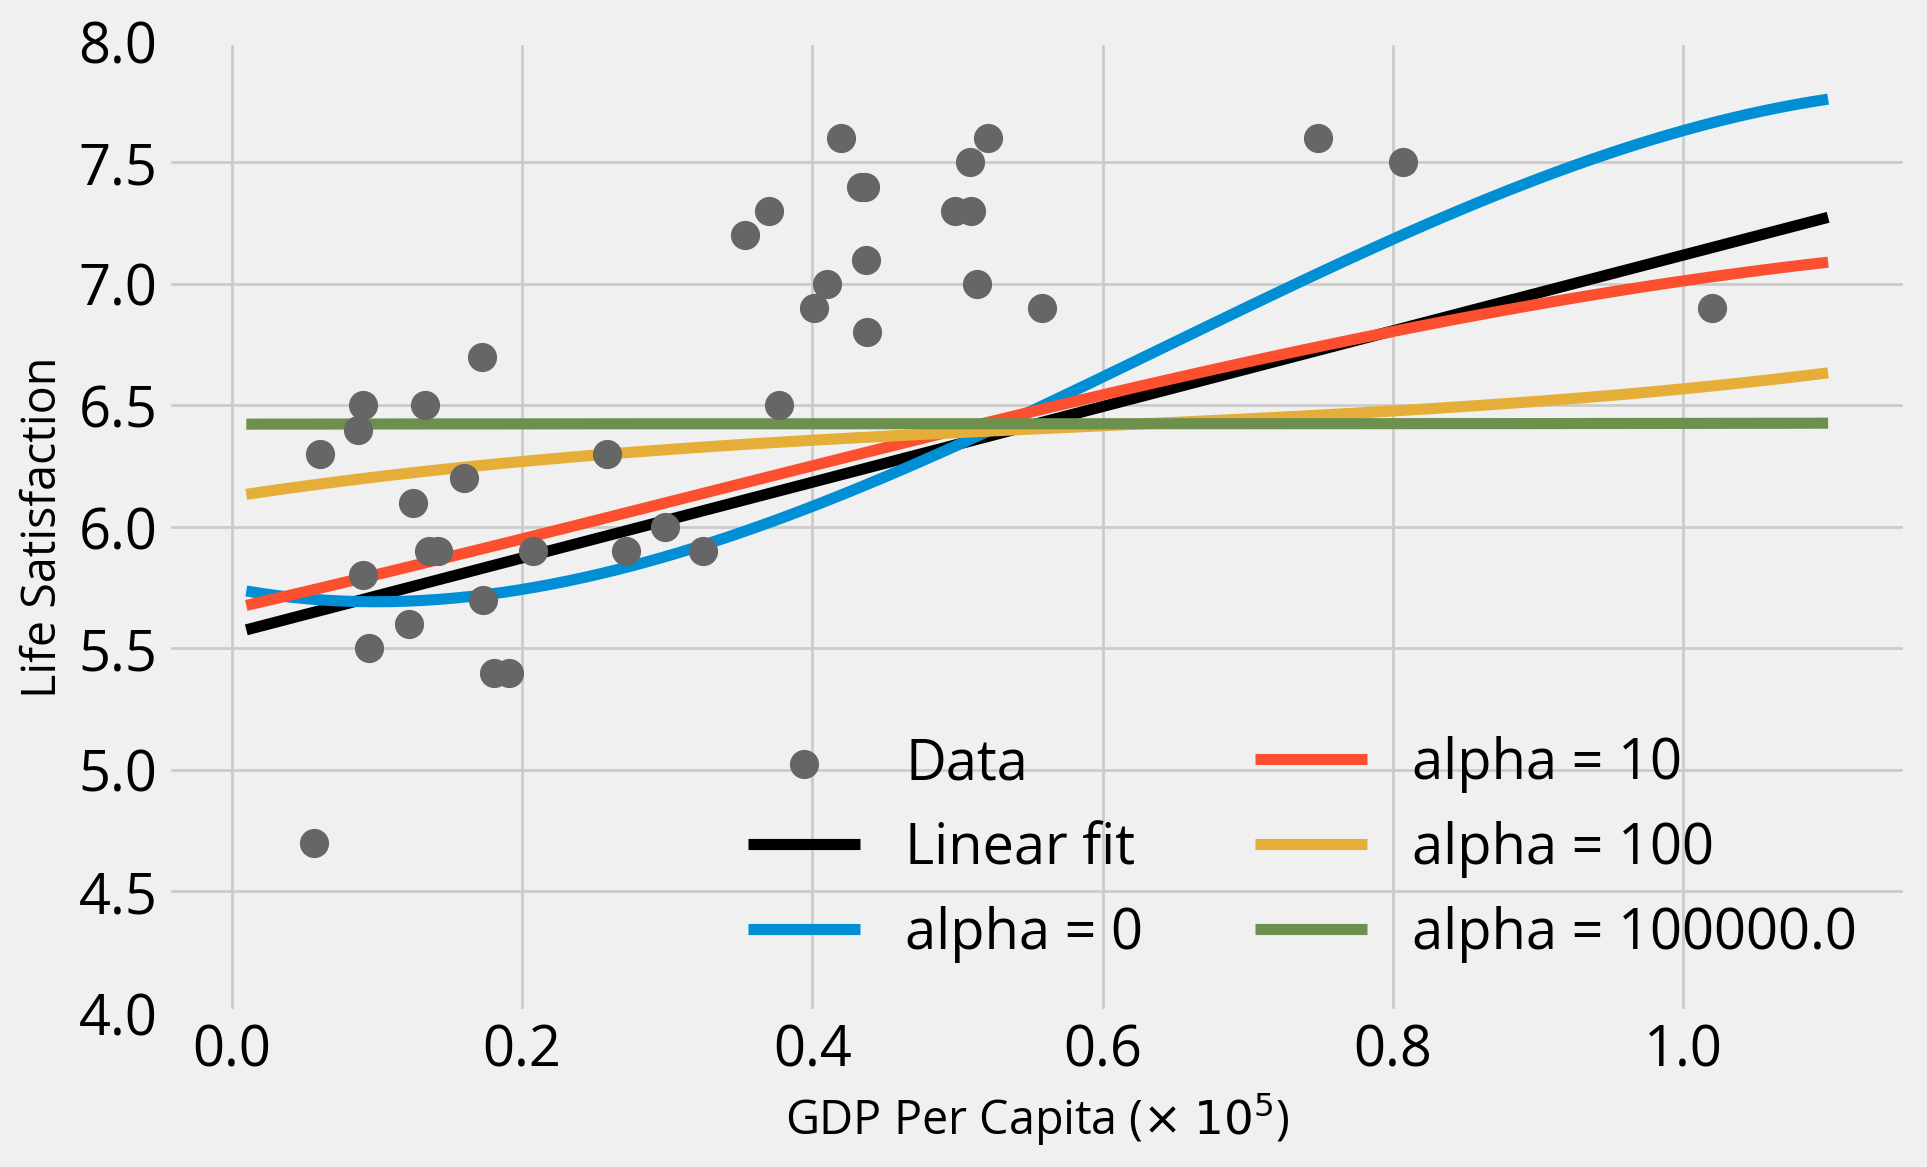

In [8]:
# Create a pre-processing pipeline
# This scales and adds polynomial features up to degree = 3
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3))

# BASELINE: Setup and fit a linear model (with scaled features)
linear = LinearRegression()
scaler = StandardScaler()
linear.fit(scaler.fit_transform(X_train), y_train)


with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    ## Plot the data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Data",
        s=100,
        zorder=10,
        color="#666666",
    )

    ## Evaluate the linear fit
    print("Linear fit")
    training_score = linear.score(scaler.fit_transform(X_train), y_train)
    print(f"Training Score = {training_score}")

    test_score = linear.score(scaler.fit_transform(X_test), y_test)
    print(f"Test Score = {test_score}")
    print()


    ## Plot the linear fit
    ax.plot(
        X_pred / 1e5,
        linear.predict(scaler.fit_transform(X_pred)),
        color="k",
        label="Linear fit",
    )

    ## Ridge regression: linear model with regularization 
    # Plot the predicted values for each alpha
    for alpha in [0, 10, 100, 1e5]:
        print(f"alpha = {alpha}")

        # Create out Ridge model with this alpha
        ridge = Ridge(alpha=alpha)

        # Fit the model on the training set
        # NOTE: Use the pipeline that includes polynomial features
        ridge.fit(pipe.fit_transform(X_train), y_train)

        # Evaluate on the training set
        training_score = ridge.score(pipe.fit_transform(X_train), y_train)
        print(f"Training Score = {training_score}")

        # Evaluate on the test set
        test_score = ridge.score(pipe.fit_transform(X_test), y_test)
        print(f"Test Score = {test_score}")

        # Plot the ridge results
        y_pred = ridge.predict(pipe.fit_transform(X_pred))
        ax.plot(X_pred / 1e5, y_pred, label=f"alpha = {alpha}")

        print()

    # Plot formatting
    ax.legend(ncol=2, loc=0)
    ax.set_ylim(4, 8)
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")

### Takeaways

- As we increase alpha, the fits become "simpler" and coefficients get closer and closer to zero — a straight line!
- When alpha = 0 (no regularization), we get the same result as when we ran `LinearRegression()` with the polynomial features
- In this case, regularization doesn't improve the fit, and the base polynomial regression (degree=3) provides the best fit

## Recap: what we learned so far

- The LinearRegression model
- The test/train split and evaluation
- Feature engineering: scaling and creating polynomial features
- The Ridge model and regularization
- Creating Pipeline() objects


## How can we improve?

More feature engineering!

In this case, I've done the hard work for you and pulled additional country properties from the OECD's website.

In [9]:
data2 = pd.read_csv("./data/gdp_vs_satisfaction_more_features.csv")

In [10]:
data2.head()

,Country,life_satisfaction,GDP per capita,Air pollution,Employment rate,Feeling safe walking alone at night,Homicide rate,Life expectancy,Quality of support network,Voter turnout,Water quality
0,Australia,7.3,50961.87,5.0,73.0,63.5,1.1,82.5,95.0,91.0,93.0
1,Austria,7.1,43724.03,16.0,72.0,80.6,0.5,81.7,92.0,80.0,92.0
2,Belgium,6.9,40106.63,15.0,63.0,70.1,1.0,81.5,91.0,89.0,84.0
3,Brazil,6.4,8670.00,10.0,61.0,35.6,26.7,74.8,90.0,79.0,73.0
4,Canada,7.4,43331.96,7.0,73.0,82.2,1.3,81.9,93.0,68.0,91.0


## Decision trees: a more sophisticated modeling algorithm

We'll move beyond simple linear regression and see if we can get a better fit.

A decision tree learns decision rules from the input features:

<img src="imgs/decision-trees-1.jpeg" width=600></img>

## A decision tree classifier for the Iris data set


<img src="imgs/decision-trees-2.png" width=600></img>

[More info on the iris data set](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

## Regression with decision trees is similar

For a specific corner of the input feature space, the decision tree predicts an output target value

<img src="imgs/decision-trees-3.png"></img>


## Decision trees suffer from overfitting

Decision trees can be very deep with many nodes — this will lead to overfitting your dataset! 

## Random forests: an *ensemble* solution to overfitting

- Introduces randomization into the fitting process to avoid overfitting
- Fits multiple decision trees on random subsets of the input data
- Avoids overfitting and leads to better overall fits

This is an example of *ensemble* learning: combining multiple estimators to achieve better overall accuracy than any one model could achieve

In [11]:
from sklearn.ensemble import RandomForestRegressor

Let's split our data into training and test sets again:

In [12]:
# Split the data 70/30
train_set, test_set = train_test_split(data2, test_size=0.3, random_state=42)

# the target labels
y_train = train_set["life_satisfaction"].values
y_test = test_set["life_satisfaction"].values

# The features
feature_cols = [col for col in data2.columns if col not in ["life_satisfaction", "Country"]]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

In [13]:
feature_cols

['GDP per capita',
 'Air pollution',
 'Employment rate',
 'Feeling safe walking alone at night',
 'Homicide rate',
 'Life expectancy',
 'Quality of support network',
 'Voter turnout',
 'Water quality']

## Let's check for correlations in our input data

- Highly correlated input variables can skew the model fits and lead to worse accuracy
- Best to remove features with high correlations (rule of thumb: coefficients > 0.7 or 0.8, typically)

In [14]:
import seaborn as sns

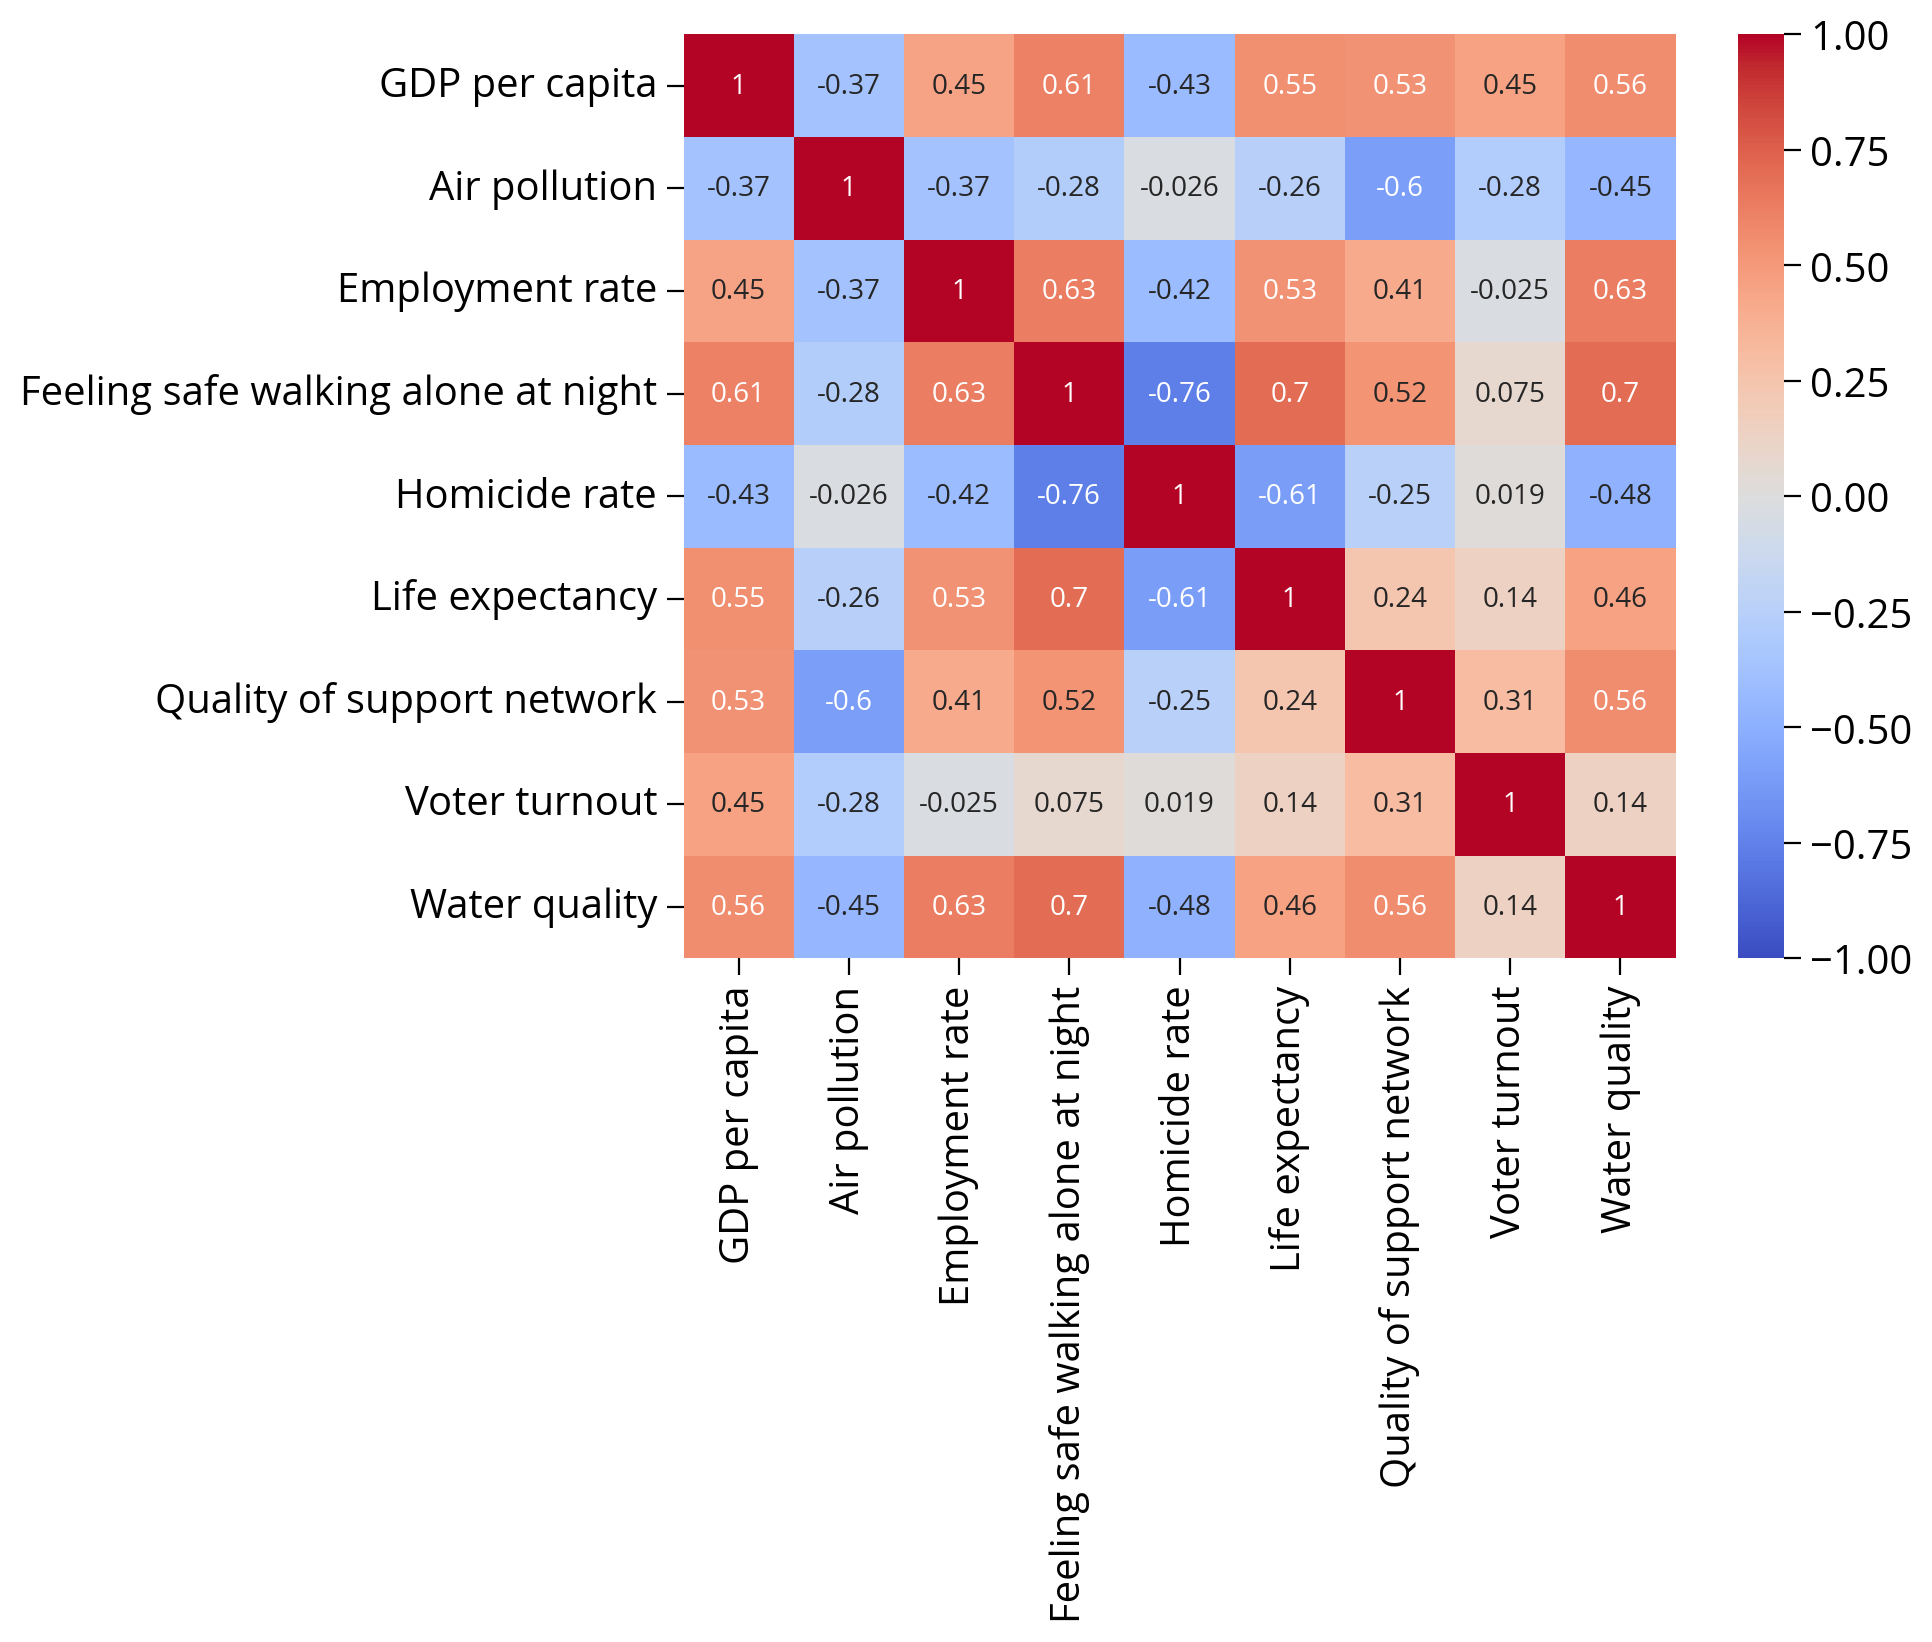

In [15]:
sns.heatmap(
    train_set[feature_cols].corr(), 
    cmap="coolwarm", 
    annot=True, 
    vmin=-1, 
    vmax=1
);

## Let's do some fitting...

**New:** `Pipelines` support models as the last step!

- Very useful for setting up reproducible machine learning analyses!
- The `Pipeline` behaves just like a model, but it runs the transformations beforehand
- Simplifies the analysis: now we can just call the `.fit()` function of the pipeline instead of the model

Establish a baseline with a linear model:

In [16]:
# Linear model pipeline with two steps
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

# Fit the pipeline
# NEW: This applies all of the transformations, and then fits the model
print("Linear regression")
linear_pipe.fit(X_train, y_train)

# NEW: Print the training score
training_score = linear_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# NEW: Print the test score
test_score = linear_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Linear regression
Training Score = 0.755333265746168
Test Score = 0.6478865590446827


Now fit a random forest:

In [17]:
# Random forest model pipeline with two steps
forest_pipe = make_pipeline(
    StandardScaler(),  # Pre-process step
    RandomForestRegressor(n_estimators=100, max_depth=2, random_state=42),  # Model step
)

# Fit a random forest
print("Random forest")
forest_pipe.fit(X_train, y_train)

# Print the training score
training_score = forest_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# Print the test score
test_score = forest_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Random forest
Training Score = 0.8460206265596556
Test Score = 0.8633845691443998


## Which variables matter the most?

Because random forests are an ensemble method with multiple estimators, the algorithm can learn which features help improve the fit the most.

- The *feature importances* are stored as the `feature_importances_` attribute
- Only available after calling `fit()`!

In [18]:
# What are the named steps?
forest_pipe.named_steps

{'standardscaler': StandardScaler(),
 'randomforestregressor': RandomForestRegressor(max_depth=2, random_state=42)}

In [19]:
# Get the forest model
forest_model = forest_pipe['randomforestregressor']

In [20]:
forest_model.feature_importances_

array([0.67746013, 0.00475431, 0.13108609, 0.06579352, 0.00985913,
       0.01767323, 0.02546804, 0.00601776, 0.06188779])

In [21]:
# Make the dataframe
importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": forest_model.feature_importances_}
).sort_values("Importance", ascending=False)

In [22]:
importance

,Feature,Importance
0,GDP per capita,0.677460
2,Employment rate,0.131086
3,Feeling safe walking alone at night,0.065794
8,Water quality,0.061888
6,Quality of support network,0.025468
5,Life expectancy,0.017673
4,Homicide rate,0.009859
7,Voter turnout,0.006018
1,Air pollution,0.004754


In [23]:
# Plot
importance.sort_values("Importance", ascending=True).hvplot.barh(
    x="Feature", y="Importance", title="Does Money Make You Happier?"
)

:Bars   [Feature]   (Importance)

## Let's improve our fitting with *k*-fold cross validation

1. Break the data into a training set and test set
1. Split the training set into *k* subsets (or folds), holding out one subset as the test set
1. Run the learning algorithm on each combination of subsets, using the average of all of the runs to find the best fitting model parameters

For more information, see the [scikit-learn docs](https://scikit-learn.org/stable/modules/cross_validation.html)



<img src="imgs/crossval.png" width=600></img>

The [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) function will automatically partition the training set into *k* folds, fit the model to the subset, and return the scores for each partition.

It takes a `Pipeline` object, the training features, and the training labels as arguments

In [24]:
from sklearn.model_selection import cross_val_score

## Let's do 3-fold cross validation

### Linear pipeline (baseline)

In [25]:
model = linear_pipe['linearregression']

In [26]:
# Make a linear pipeline
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

# Run the 3-fold cross validation
scores = cross_val_score(
    linear_pipe,
    X_train,
    y_train,
    cv=3,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [ 0.02064625 -0.84773581 -0.53652985]
Scores mean =  -0.4545398042994617
Score std dev =  0.35922474493059153


### Random forest model

In [27]:
# Make a random forest pipeline
forest_pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 3-fold cross validation
scores = cross_val_score(
    forest_pipe,
    X_train,
    y_train,
    cv=3,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.5208505  0.78257711 0.66646144]
Scores mean =  0.6566296832385494
Score std dev =  0.1070753730357217


### Takeaway: the random forest model is clearly more accurate

## Question: Why did I choose to use 100 estimators in the RF model?

- In this case, I didn't have a good reason
- `n_estimators` is a model *hyperparameter*
- In practice, it's best to optimize the hyperparameters **and** the model parameters `(via the fit() method)`

**This is when cross validation becomes very important**

- Optimizing hyperparameters with a single train/test split means you are really optimizing based on your test set.
- If you use cross validation, a final test set will always be held in reserve to do a final evaluation.

### Enter GridSearchCV

A utility function that will:
- Iterate over a grid of hyperparameters
- Perform *k*-fold cross validation
- Return the parameter combination with the best overall score

[More info](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [28]:
from sklearn.model_selection import GridSearchCV

Let's do a search over the `n_estimators` parameter and the `max_depth` parameter:

In [29]:
# Create our regression pipeline
pipe = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

### Make the grid of parameters to search
 
- **NOTE:** you must prepend the name of the pipeline step
- The syntax for parameter names is:  "[step name]__[parameter name]"

In [30]:
pipe.named_steps

{'standardscaler': StandardScaler(),
 'randomforestregressor': RandomForestRegressor(random_state=42)}

In [31]:
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_step}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30, 50, 100, 200],
 'randomforestregressor__max_depth': [2, 5, 7, 9, 13, 21, 33, 51]}

In [32]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)

# Run the search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [2, 5, 7, 9, 13,
                                                              21, 33, 51],
                         'randomforestregressor__n_estimators': [5, 10, 15, 20,
                                                                 30, 50, 100,
                                                                 200]},
             verbose=1)

In [33]:
# The best estimator
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=7, random_state=42))])

In [34]:
# The best hyper parameters
grid.best_params_

{'randomforestregressor__max_depth': 7,
 'randomforestregressor__n_estimators': 100}

### Now let's evaluate!

We'll define a helper utility function to calculate the accuracy in terms of the mean absolute percent error

In [35]:
def evaluate_mape(model, X_test, y_test):
    """
    Given a model and test features/targets, print out the 
    mean absolute error and accuracy
    """
    # Make the predictions
    predictions = model.predict(X_test)

    # Absolute error
    errors = abs(predictions - y_test)
    avg_error = np.mean(errors)

    # Mean absolute percentage error
    mape = 100 * np.mean(errors / y_test)

    # Accuracy
    accuracy = 100 - mape

    print("Model Performance")
    print(f"Average Absolute Error: {avg_error:0.4f}")
    print(f"Accuracy = {accuracy:0.2f}%.")

    return accuracy

#### Linear model results

In [36]:
# Setup the pipeline
linear = make_pipeline(StandardScaler(), LinearRegression())

# Fit on train set
linear.fit(X_train, y_train)

# Evaluate on test set
evaluate_mape(linear, X_test, y_test)

Model Performance
Average Absolute Error: 0.3281
Accuracy = 94.93%.


94.92864894582036

#### Random forest results with default parameters

In [37]:
# Initialize the pipeline
base_model = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))

# Fit the training set
base_model.fit(X_train, y_train)

# Evaluate on the test set
base_accuracy = evaluate_mape(base_model, X_test, y_test)

Model Performance
Average Absolute Error: 0.2322
Accuracy = 96.43%.


#### The random forest model with the optimal hyperparameters

Small improvement!

In [38]:
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=7, random_state=42))])

In [39]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
random_accuracy = evaluate_mape(best_random, X_test, y_test)

# What's the improvement?
improvement = 100 * (random_accuracy - base_accuracy) / base_accuracy
print(f'Improvement of {improvement:0.4f}%.')

Model Performance
Average Absolute Error: 0.2320
Accuracy = 96.43%.
Improvement of 0.0011%.


## Recap

- Decision trees and random forests
- Cross validation with `cross_val_score`
- Optimizing hyperparameters with `GridSearchCV`
- Feature importances from random forests

## Part 2: Modeling residential sales in Philadelphia

In this part, we'll use a random forest model and housing data from the Office of Property Assessment to predict residential sale prices in Philadelphia

### Machine learning models are increasingly common in the real estate industry
  - [Airbnb recommends pricing to hosts](https://spectrum.ieee.org/computing/software/the-secret-of-airbnbs-pricing-algorithm)
  - [Trulia converts house photos to house features](https://www.trulia.com/blog/tech/image-recognition/)
  - [Zillow's Zestimate](https://www.zillow.com/research/zestimate-forecast-methodology/)

### The hedonic approach to housing prices

- An econometric approach
- Deconstruct housing price to the value of each of its parts
- Captures the "price premium" consumers are willing to pay for an extra bedroom or garage

### What contributes to the price of a house?

- Property characteristics, e.g, size of the lot and the number of bedrooms
- Neighborhood features based on amenities or disamenities, e.g., access to transit or exposure to crime
- Spatial component that captures the tendency of housing prices to depend on the prices of neighboring homes

**Note:** We'll focus on the first two components in this analysis

### Why are these kinds of models important?

- They are used widely by cities to perform property assessment valuation
    - Train a model on recent residential sales
    - Apply the model to the entire residential housing stock to produce assessments
- Biases in the algorithmic models have important consequences for city residents


**Too often, these models perpetuate inequality: low-value homes are over-assessed and high-value homes are under-assessed**

### Philadelphia's assessments are...not good

- [City Controller analysis of property assessments: Part 1](https://controller.phila.gov/philadelphia-audits/property-assessment-review/)
- [City Controller analysis of assessments: Part 2](https://controller.phila.gov/philadelphia-audits/opa-accuracy-2023/)
- [Urban Spatial paper on algorithmic fairness with a case study on modeling Philadelphia's home values](https://urbanspatial.github.io/AlgorithmicFairness_ACodebasedPrimerForPublicSectorDataScientists)


### Data from the Office of Property Assessment

Let's download data for properties in Philadelphia that had their last sale during 2022 (the last full calendar year)

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [40]:
import requests

In [41]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# Only pull 2022 sales for single family residential properties
where = "sale_date >= '2022-01-01' and sale_date <= '2022-12-31'"
where = where + " and category_code_description IN ('SINGLE FAMILY', 'Single Family')"

In [42]:
# Create the query
query = f"SELECT * FROM opa_properties_public WHERE {where}"

# Make the request
params = {"q": query, "format": "geojson", "where": where}
response = requests.get(carto_url, params=params)

# Make the GeoDataFrame
salesRaw = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

In [43]:
salesRaw.head()

,geometry,cartodb_id,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,central_air,cross_reference,date_exterior_condition,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,fuel,garage_spaces,garage_type,general_construction,geographic_ward,homestead_exemption,house_extension,house_number,interior_condition,location,mailing_address_1,mailing_address_2,mailing_care_of,mailing_city_state,mailing_street,mailing_zip,market_value,market_value_date,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,off_street_open,other_building,owner_1,owner_2,parcel_number,parcel_shape,quality_grade,recording_date,registry_number,sale_date,sale_price,separate_utilities,sewer,site_type,state_code,street_code,street_designation,street_direction,street_name,suffix,taxable_building,taxable_land,topography,total_area,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid
0,POINT (-75.14337 40.00957),1077,2022-05-24T00:00:00Z,D,415' N OF ERIE AVE,54230032,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,198,N,None,None,45.0,0.0,0.0,4,0.0,16.0,None,0.0,None,A,43,0,None,3753,4,3753 N DELHI ST,None,None,None,DELRAY BEACH FL,4899 NW 6TH STREET,33445,73800,None,1.0,3.0,NaN,2.0,1683.0,None,RJ SIMPLE SOLUTION LLC,None,432345900,E,C,2023-10-04T00:00:00Z,100N040379,2022-06-13T00:00:00Z,35000,None,None,None,FL,28040,ST,N,DELHI,None,59040.0,14760.0,F,720.0,960.0,H,None,None,None,I,1942,Y,19140,RM1,1001175031,24,ROW PORCH FRONT,394097870
1,POINT (-75.13389 40.03928),1108,2022-05-24T00:00:00Z,H,241' N OF CHEW ST,54230133,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,275,N,None,None,95.0,0.0,0.0,7,0.0,15.0,None,1.0,None,B,61,0,None,5732,4,5732 N 7TH ST,WALKER MICHAEL,None,None,SICKLERVILLE NJ,44 FARMHOUSE RD,08081,133400,None,1.0,3.0,NaN,2.0,1920.0,None,WALKER MICHAEL,None,612234600,E,C,2023-10-04T00:00:00Z,135N7 61,2022-08-21T00:00:00Z,21000,None,None,None,NJ,87930,ST,N,7TH,None,106720.0,26680.0,F,1425.0,1164.0,H,None,None,None,I,1925,Y,19120,RSA5,1001602509,24,ROW PORCH FRONT,394097901
2,POINT (-75.07249 40.01381),1280,2022-05-24T00:00:00Z,D,"119'11 1/2"" NE",54228837,H30,SEMI/DET 2 STY MASONRY,1,SINGLE FAMILY,299,N,None,None,76.0,0.0,0.0,4,0.0,20.0,None,0.0,None,B,62,0,None,5033,4,5033 DITMAN ST,CSC INGEO,None,None,PHILADELPHIA PA,5033 DITMAN ST,19124-2230,119100,None,1.0,3.0,NaN,2.0,698.0,None,LISHANSKY MARINA,None,622444400,E,C,2023-10-02T00:00:00Z,89N17 208,2022-12-28T00:00:00Z,1,None,None,None,PA,28660,ST,None,DITMAN,None,95280.0,23820.0,F,1523.0,1190.0,B,None,None,None,I,1945,None,19124,RSA5,1001181518,32,TWIN CONVENTIONAL,394098073
3,POINT (-75.12854 40.03916),1693,2022-05-24T00:00:00Z,None,"71'8"" E LAWRENCE ST",54226519,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,274,None,None,None,88.0,0.0,0.0,4,0.0,14.0,None,0.0,None,A,61,0,None,416,4,416 W GRANGE AVE,None,None,None,PHILADELPHIA PA,416 W GRANGE AVE,19120-1854,124100,None,1.0,3.0,NaN,2.0,957.0,None,WALLACE DANE,None,612061100,E,C,2023-09-25T00:00:00Z,122N2 150,2022-10-26T00:00:00Z,1,None,None,None,PA,38040,AVE,W,GRANGE,None,99280.0,24820.0,F,1241.0,1104.0,None,None,None,None,I,1953,Y,19120,RSA5,1001249126,24,ROW PORCH FRONT,394098484
4,POINT (-75.17362 39.99887),2606,2022-05-24T00:00:00Z,D,"261'4"" N OF SOMERSET",54217081,O50,ROW 3 STY MASONRY,1,SINGLE FAMILY,172,N,None,None,56.0,0.0,0.0,4,0.0,16.0,None,0.0,None,B,38,0,None,2834,4,2834 N 26TH ST,NEAL KIYONNA,None,None,PHILADELPHIA PA,6007 N FRONT ST,19120,92900,None,0.0,5.0,NaN,3.0,2457.0,None,NEAL KIYONNA,None,381152100,E,C+,2023-08-28T00:00:00Z,035N230348,2022-05-11T00:00:00Z,1,None,None,None,PA,88300,ST,N,26TH,None,74320.0,18580.0,F,896.0,1636.0,H,None,None,None,I,1940,Y,19132,RSA5,1001643492,24,ROW PORCH FRONT,394099946


In [44]:
len(salesRaw)

24457

### The OPA is messy

**Lots** of missing data.

We can use the [missingno](https://github.com/ResidentMario/missingno) package to visualize the missing data easily.

In [45]:
import missingno as msno

In [46]:
# We'll visualize the first half of columns
# and then the second half
ncol = len(salesRaw.columns)

fields1 = salesRaw.columns[:ncol//2]
fields2 = salesRaw.columns[ncol//2:]

In [47]:
ncol

80

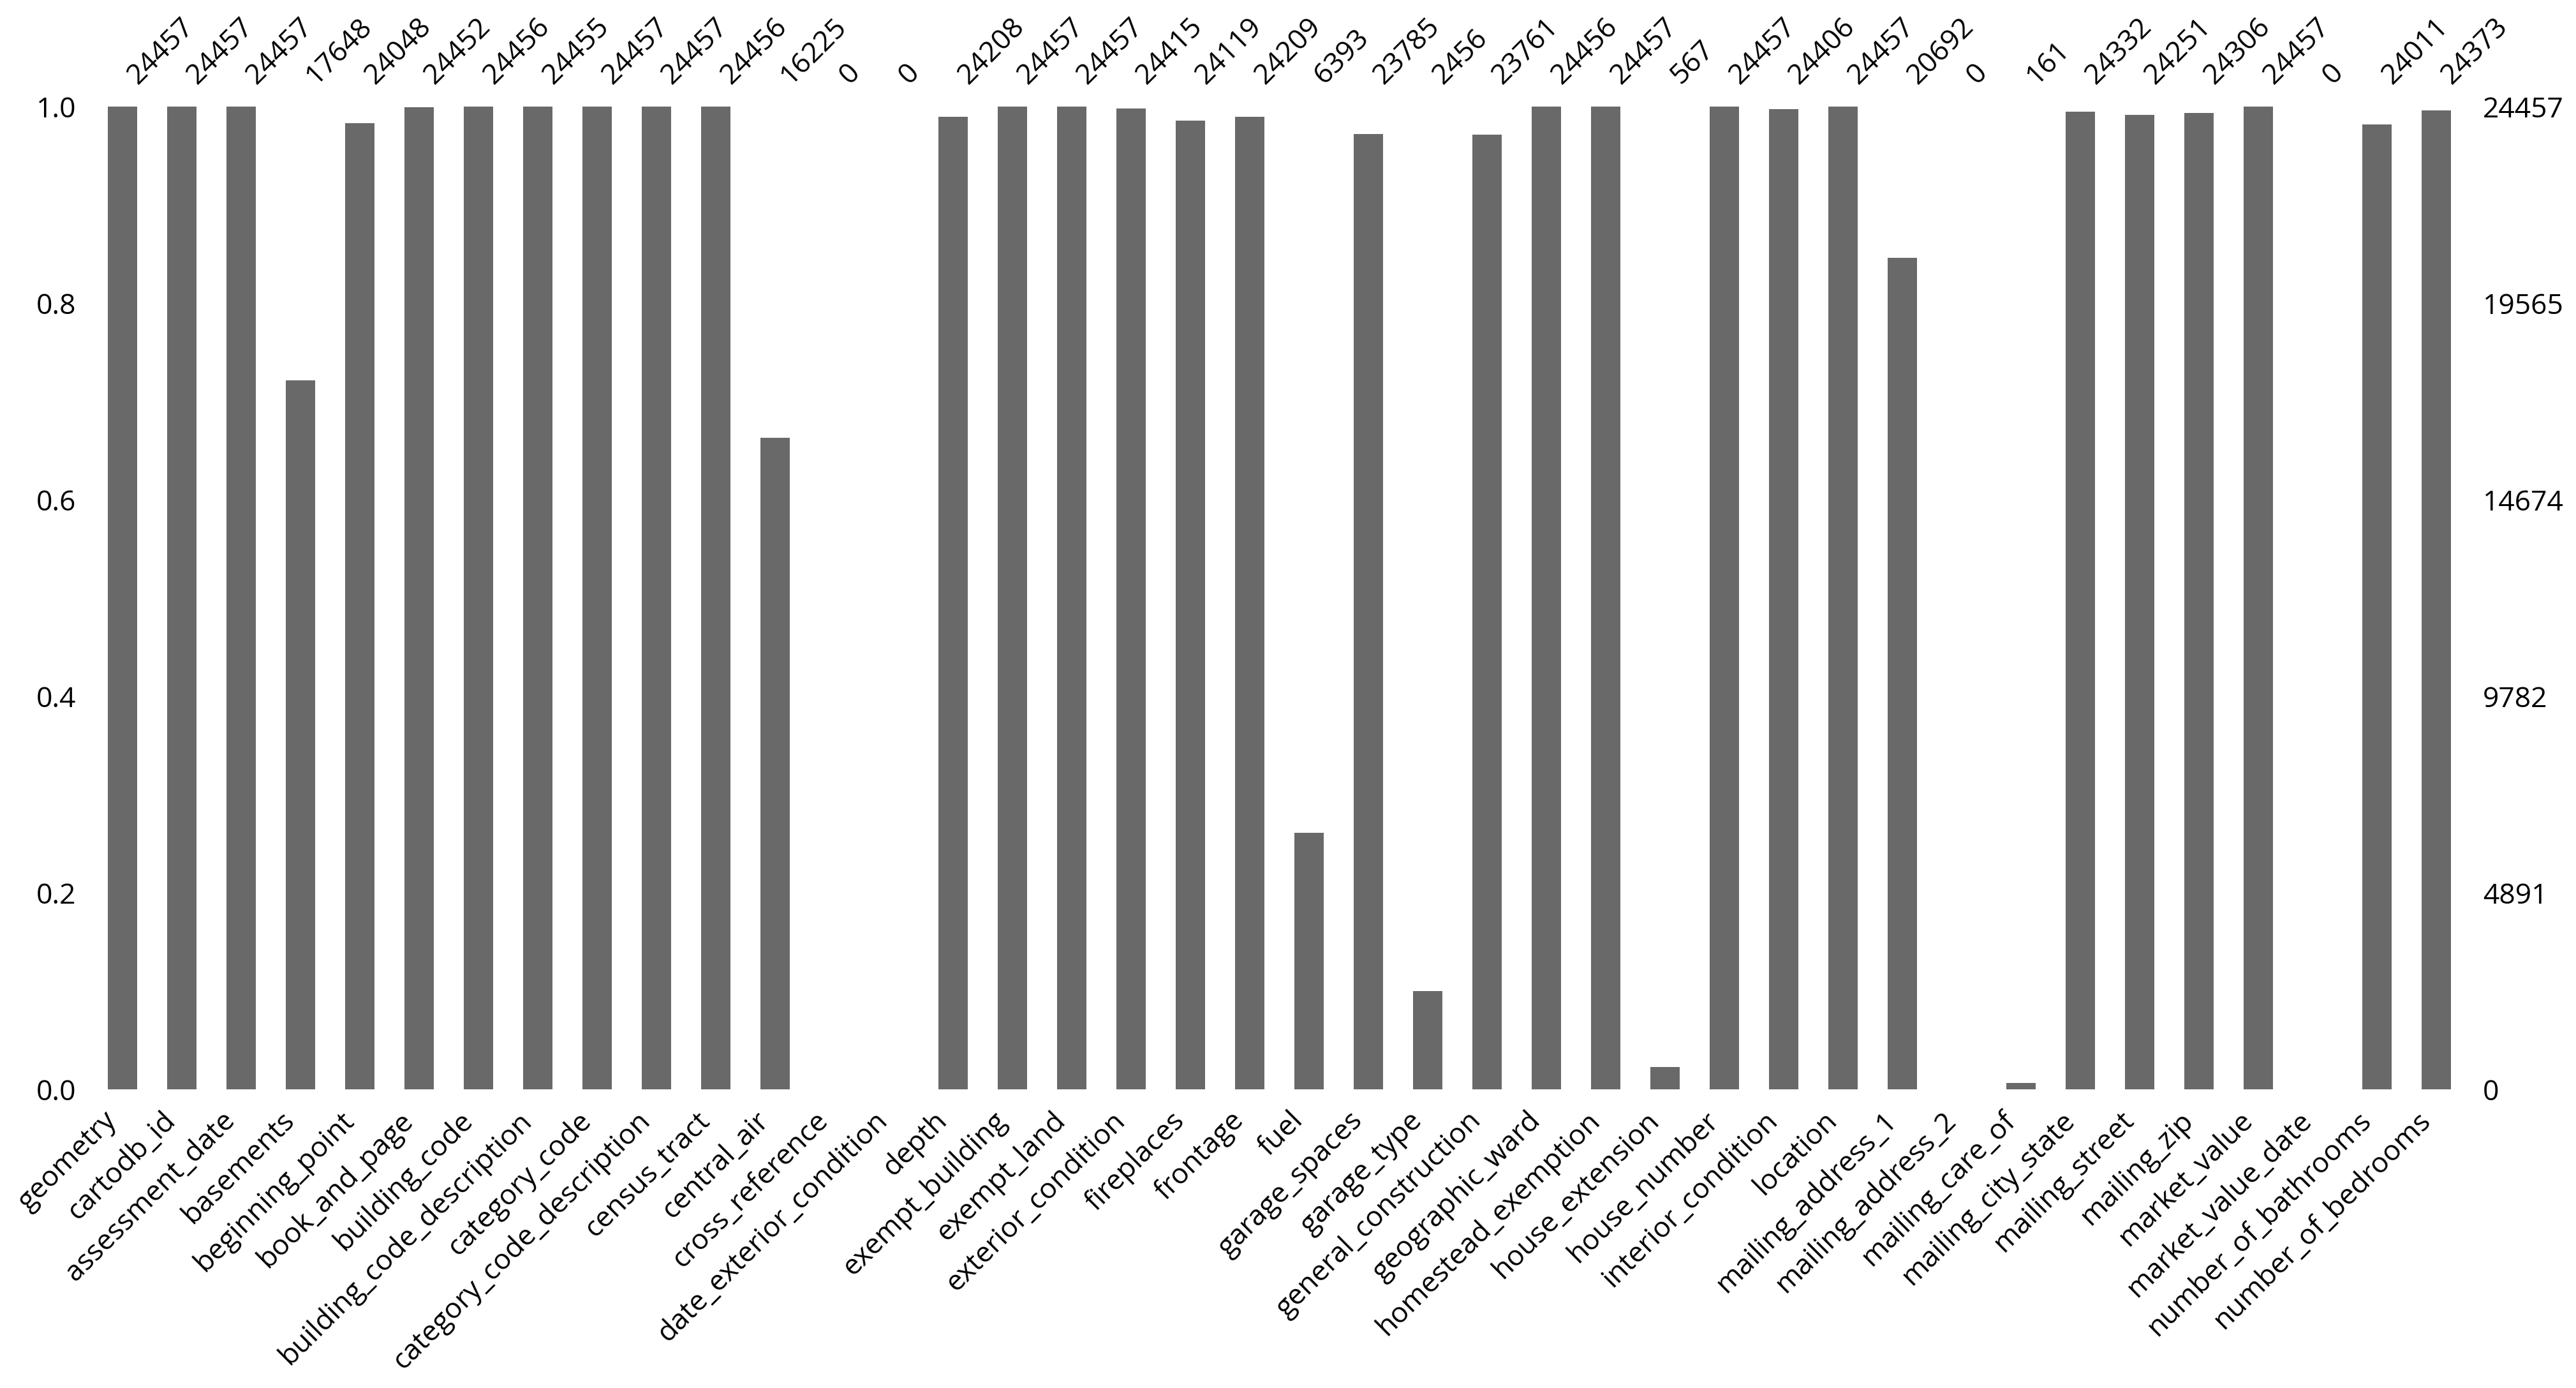

In [48]:
# The first half of columns
msno.bar(salesRaw[fields1]);

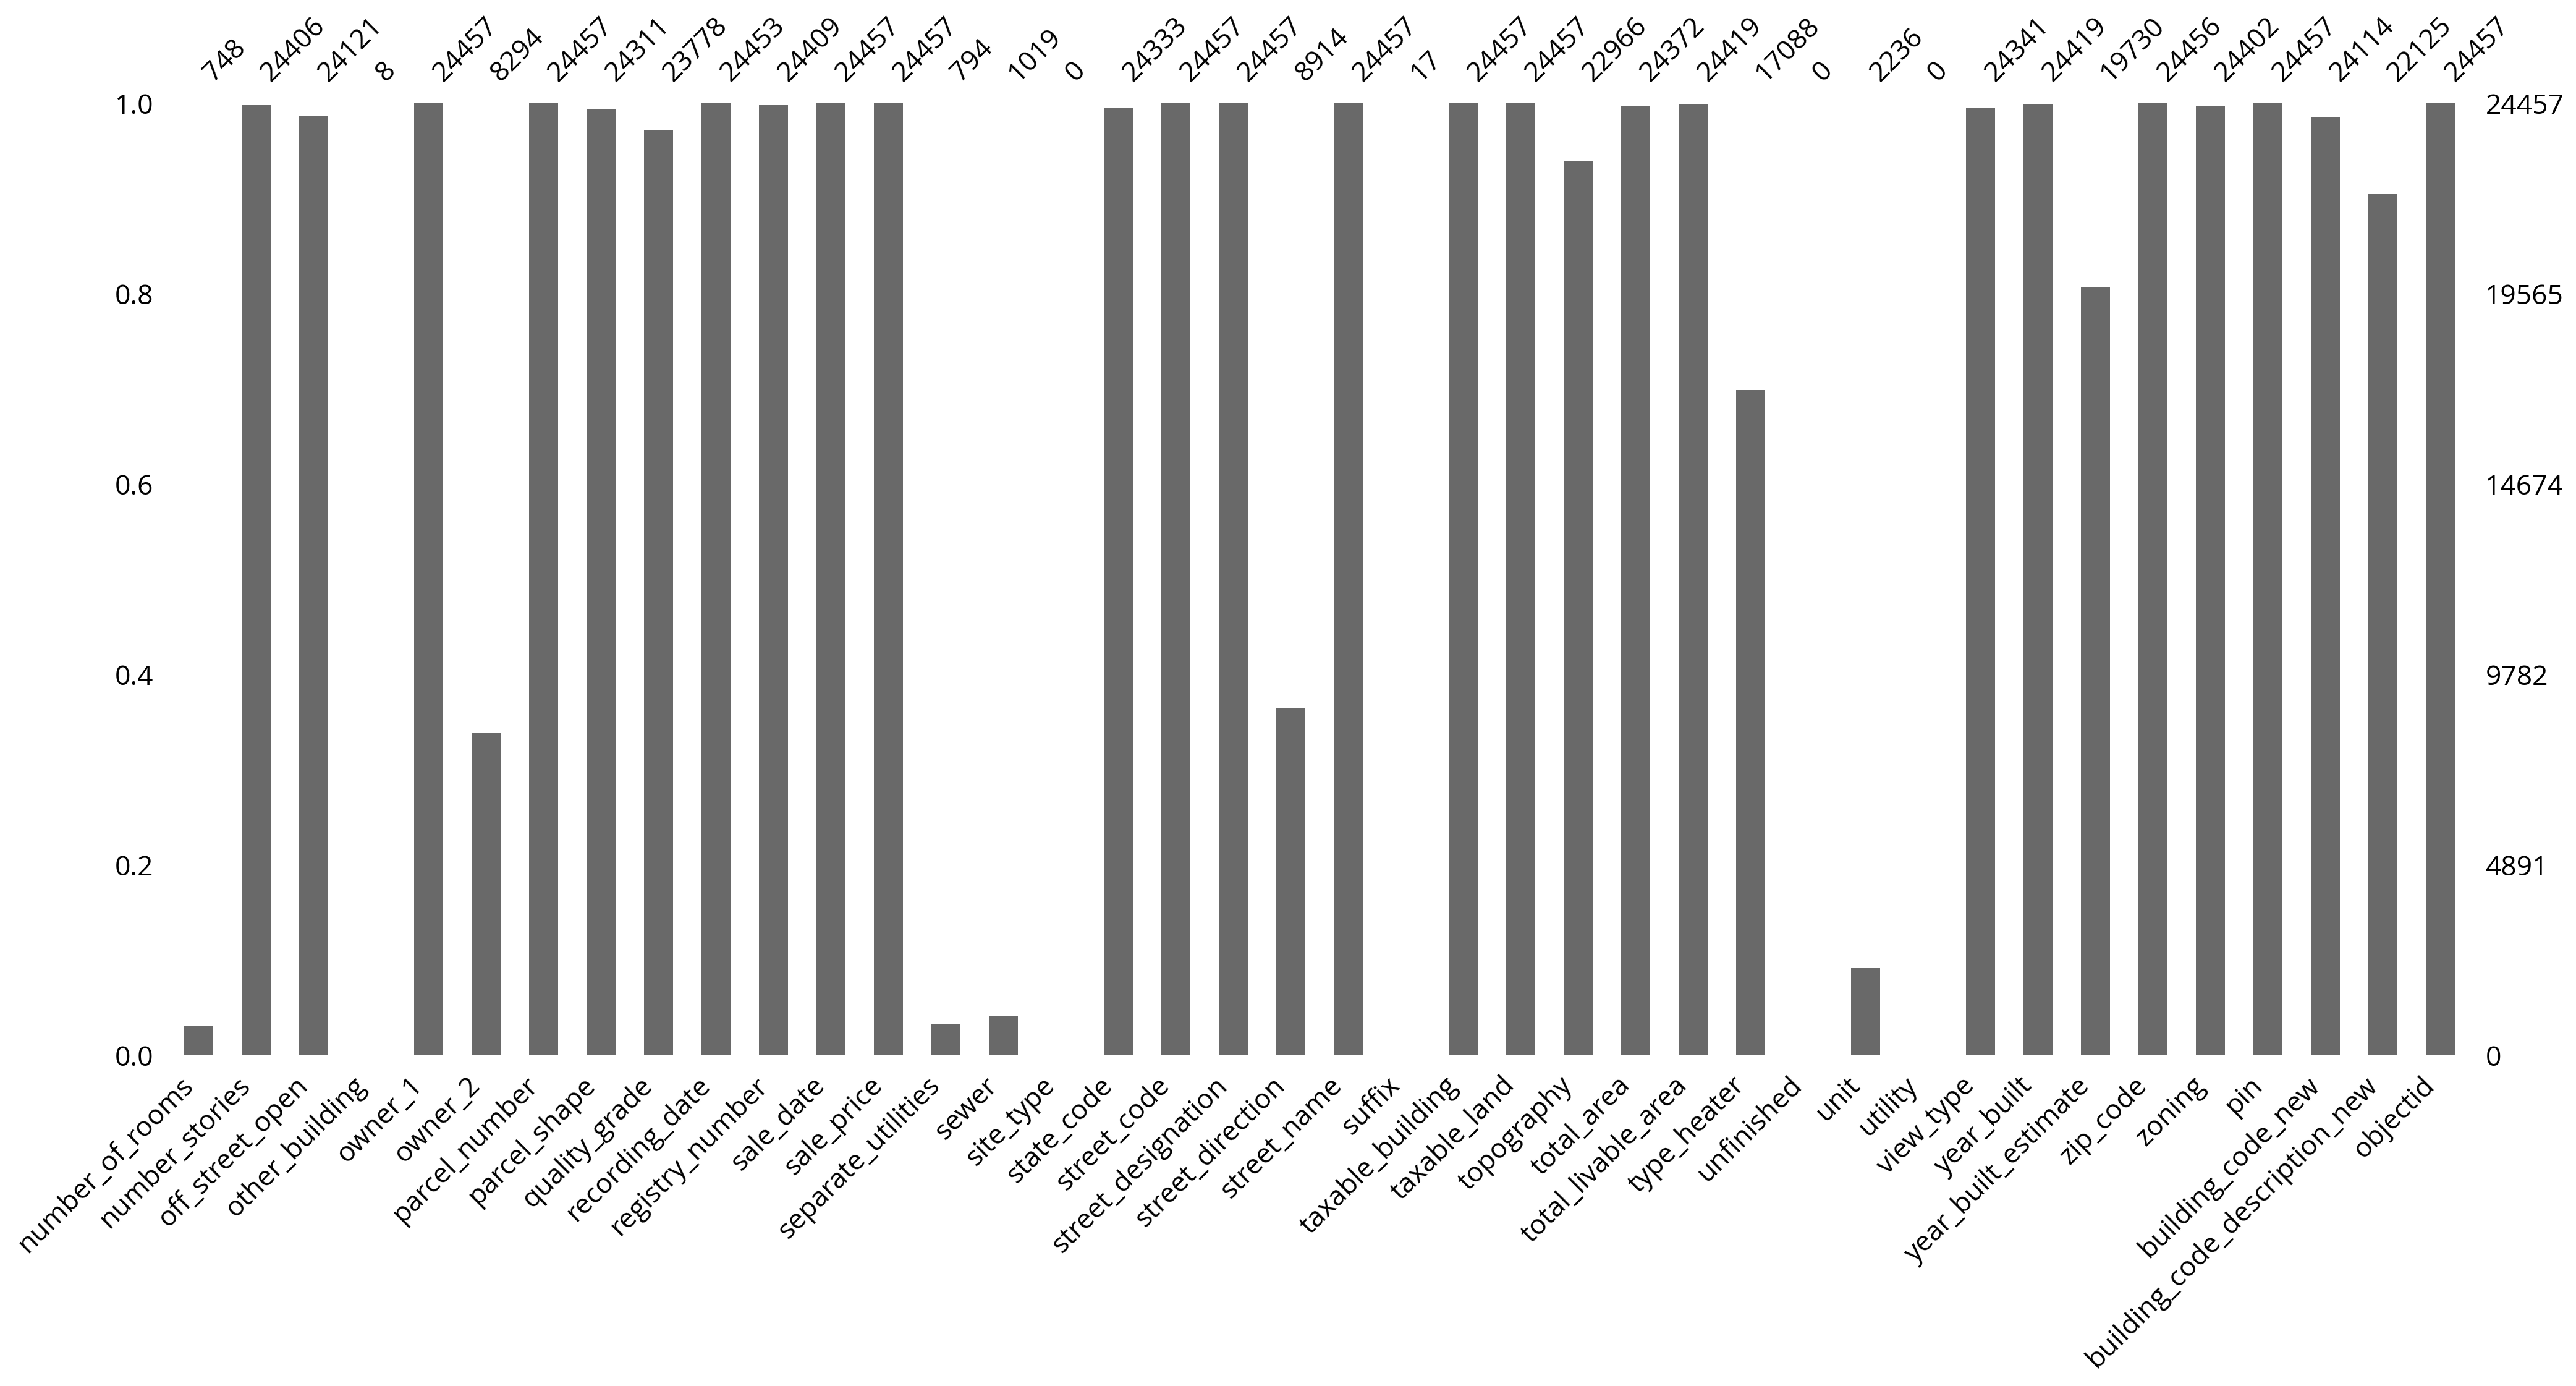

In [49]:
# The second half of columns
msno.bar(salesRaw[fields2]);

In [50]:
# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols].dropna()

# Trim zip code to only the first five digits
sales['zip_code'] = sales['zip_code'].astype(str).str.slice(0, 5)

In [51]:
len(sales)

23479

In [52]:
# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [53]:
len(sales)

17684

### Let's focus on numerical features only first

In [54]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels: log of sale price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

# The features
feature_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

In [55]:
# Make a random forest pipeline
forest = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 10-fold cross validation
scores = cross_val_score(
    forest,
    X_train,
    y_train,
    cv=10,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.31590527 0.24439146 0.34501458 0.29939277 0.30929715 0.32289248
 0.429871   0.2990362  0.32022697 0.33481283]
Scores mean =  0.32208407045926973
Score std dev =  0.04426497345382467


In [56]:
# Fit on the training data
forest.fit(X_train, y_train)

# What's the test score?
forest.score(X_test, y_test)

0.3114781077490535

### Which variables were most important?

In [57]:
# Extract the regressor from the pipeline
regressor = forest["randomforestregressor"]

In [58]:
# Create the data frame of importances
importance = pd.DataFrame(
    {
     "Feature": feature_cols, 
     "Importance": regressor.feature_importances_
    }
).sort_values(by="Importance")

importance.hvplot.barh(x="Feature", y="Importance")

:Bars   [Feature]   (Importance)

**Takeaway**: Number of bathrooms and area-based features still important

## To be continued next lecture...